In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
import random
import matplotlib.pyplot as plt

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, vars_to_predict=None):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i-1))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_out):
        cols.append(df[vars_to_predict].shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in vars_to_predict]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in vars_to_predict]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# node 1 indexes
target_variable_demand_node1 = [1]
target_variable_pressures_node1 = [33]
target_variable_flows_node1 = [64]
#node 16 indexes
target_variable_demand_node16 = [16]
target_variable_pressures_node16 = [48]
target_variable_flows_node16 = [79]
#node 29 indexes
target_variable_demand_node29 = [29]
target_variable_pressures_node29 = [61]
target_variable_flows_node29 = [92]


reframed_demand_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node1)
reframed_pressures_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node1)
reframed_flows_node1 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node1)

reframed_demand_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node16)
reframed_pressures_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node16)
reframed_flows_node16 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node16)

reframed_demand_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_demand_node29)
reframed_pressures_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_pressures_node29)
reframed_flows_node29 = series_to_supervised(values, 1, 1, vars_to_predict=target_variable_flows_node29)

reframed_demand_node1 = reframed_demand_node1.drop(reframed_demand_node1.columns[1], axis=1)
reframed_pressures_node1 = reframed_pressures_node1.drop(reframed_pressures_node1.columns[33], axis=1)
reframed_flows_node1 = reframed_flows_node1.drop(reframed_flows_node1.columns[64], axis=1)

reframed_demand_node16 = reframed_demand_node16.drop(reframed_demand_node16.columns[16], axis=1)
reframed_pressures_node16 = reframed_pressures_node16.drop(reframed_pressures_node16.columns[48], axis=1)
reframed_flows_node16 = reframed_flows_node16.drop(reframed_flows_node16.columns[79], axis=1)

reframed_demand_node29 = reframed_demand_node29.drop(reframed_demand_node29.columns[29], axis=1)
reframed_pressures_node29 = reframed_pressures_node29.drop(reframed_pressures_node29.columns[61], axis=1)
reframed_flows_node29 = reframed_flows_node29.drop(reframed_flows_node29.columns[92], axis=1)

In [9]:
demands = [reframed_demand_node1, reframed_demand_node16, reframed_demand_node29]
pressures = [reframed_pressures_node1, reframed_pressures_node16, reframed_pressures_node29]
flows = [reframed_flows_node1, reframed_flows_node16, reframed_flows_node29]

parameters = [demands, pressures, flows]

In [10]:
MAE_scaled = []
RMSE_scaled = []
R2_scaled = []
MAE = []
RMSE = []
R2 = []
sensors_covered = []

for run in range(1,11):
    for parameter in parameters:
        for node in parameter:
            #select random columns to drop
            columns_to_drop = random.sample(list(node.columns), 8)
            # Drop the selected columns from the dataframe
            if node.columns[-1] in columns_to_drop:
                columns_to_drop.remove(node.columns[-1])
            node.drop(columns_to_drop, axis=1, inplace=True)
            print('Node shape: ', node.shape)

            # split into train and test sets
            values = node.values
            scaled = scaler.fit_transform(values)
            train, test = train_test_split(scaled, test_size=0.2, random_state=0)

            # split into input and outputs
            train_X, train_y = train[:, :-1], train[:, -1]
            test_X, test_y = test[:, :-1], test[:, -1]

            #define model
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.9,
                colsample_bytree=0.8,
                random_state=42
            )

            # fit the model on the training data
            model.fit(train_X, train_y)

            # make predictions on the test data
            y_pred = model.predict(test_X)

            # calculate the mean squared error
            mae = mean_absolute_error(test_y, y_pred)
            MAE_scaled.append(mae)
            print(f'Run {run} Scaled Mean Absolute Error:', mae)
            rmse = sqrt(mean_squared_error(test_y, y_pred))
            RMSE_scaled.append(rmse)
            print(f'Run {run} Scaled RMSE: %.3f' % rmse)
            r2 = r2_score(test_y, y_pred)
            print(f'Run {run} Scaled R^2: %.3f' % r2)
            R2_scaled.append(r2)

            percentage_list = round(node.shape[1] / 96 * 100)
            sensors_covered.append(percentage_list)
            
            test_y = test_y.reshape((len(test_y), 1))
            inv_test_y = concatenate((test_y, test_X[:, -96:]), axis=1)
            test_y_inverse = scaler.inverse_transform(inv_test_y)
            test_y_inverse = test_y_inverse[:,0]

            y_pred = y_pred.reshape((len(y_pred), 1))
            inv_y_pred = concatenate((y_pred, test_X[:, -96:]), axis=1)
            y_pred_inverse = scaler.inverse_transform(inv_y_pred)
            y_pred_inverse = y_pred_inverse[:,0]

            # evaluate scaled errors
            mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
            MAE.append(mae_inverse)
            print('Mean Absolute Error:', mae_inverse)
            rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
            RMSE.append(rmse_inverse)
            print('RMSE: %.3f' % rmse_inverse)
            r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
            R2.append(r2_inverse)
            print('R^2: %.3f' % r2_inverse)


    #         # make a prediction
    #         yhat = model.predict(test_X)
    #         test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
    #         # invert scaling for forecast
    #         print(yhat.shape)
    #         yhat_reshaped = yhat.reshape(-1, 1)
    #         scaler.min_ = scaler.min_.reshape(-1, 1)
    #         inv_yhat = concatenate((yhat_reshaped, test_X[:, 1:]), axis=1)
    #         print(yhat_reshaped.shape)
    #         print(test_X[:, 1:].shape)
    #         print(scaler.min_.shape)
    #         inv_yhat = scaler.inverse_transform(inv_yhat)
    #         inv_yhat = inv_yhat[:,0]
    #         # invert scaling for actual
    #         test_y = test_y.reshape((len(test_y), 1))
    #         inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    #         inv_y = scaler.inverse_transform(inv_y)
    #         inv_y = inv_y[:,0]
    #         # calculate RMSE
    #          # calculate the mean squared error
    #         mae = mean_absolute_error(inv_y, inv_yhat)
    #         print(f'Mean Absolute Error Run {run}:', mae)
    #         rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    #         print(f'Test RMSE: %.3f Run {run}' % rmse)

Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.02019174
Run 1 Scaled RMSE: 0.026
Run 1 Scaled R^2: 0.974
Mean Absolute Error: 172.27591
RMSE: 0.026
R^2: 0.974
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.005471521
Run 1 Scaled RMSE: 0.007
Run 1 Scaled R^2: 0.998
Mean Absolute Error: 46.683018
RMSE: 0.007
R^2: 0.998
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.013698847
Run 1 Scaled RMSE: 0.018
Run 1 Scaled R^2: 0.988
Mean Absolute Error: 116.87857
RMSE: 0.018
R^2: 0.988
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.0012640982
Run 1 Scaled RMSE: 0.002
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 10.785285
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.0009238951
Run 1 Scaled RMSE: 0.001
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 7.8826714
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.00040998042
Run 1 Scaled RMSE: 0.001
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 3.4979527
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.00026827736
Run 1 Scaled RMSE: 0.000
Run 1 Scaled R^2: 1.000
Mean Absolute Error: 2.2889438
RMSE: 0.000
R^2: 1.000
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.0035876047
Run 1 Scaled RMSE: 0.005
Run 1 Scaled R^2: 0.999
Mean Absolute Error: 30.609446
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 88)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 1 Scaled Mean Absolute Error: 0.009332448
Run 1 Scaled RMSE: 0.012
Run 1 Scaled R^2: 0.995
Mean Absolute Error: 79.62445
RMSE: 0.012
R^2: 0.995
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.02019733
Run 2 Scaled RMSE: 0.026
Run 2 Scaled R^2: 0.974
Mean Absolute Error: 172.32362
RMSE: 0.026
R^2: 0.974
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.00567239
Run 2 Scaled RMSE: 0.007
Run 2 Scaled R^2: 0.998
Mean Absolute Error: 48.396828
RMSE: 0.007
R^2: 0.998
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.013762902
Run 2 Scaled RMSE: 0.018
Run 2 Scaled R^2: 0.988
Mean Absolute Error: 117.42508
RMSE: 0.018
R^2: 0.988
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.0013285313
Run 2 Scaled RMSE: 0.002
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 11.3350315
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.0009025263
Run 2 Scaled RMSE: 0.001
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 7.700354
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.00062136276
Run 2 Scaled RMSE: 0.001
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 5.301467
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.00029721353
Run 2 Scaled RMSE: 0.000
Run 2 Scaled R^2: 1.000
Mean Absolute Error: 2.5358312
RMSE: 0.000
R^2: 1.000
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.0036704913
Run 2 Scaled RMSE: 0.005
Run 2 Scaled R^2: 0.999
Mean Absolute Error: 31.316635
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 80)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 2 Scaled Mean Absolute Error: 0.00926435
Run 2 Scaled RMSE: 0.012
Run 2 Scaled R^2: 0.995
Mean Absolute Error: 79.04343
RMSE: 0.012
R^2: 0.995
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.020186288
Run 3 Scaled RMSE: 0.026
Run 3 Scaled R^2: 0.974
Mean Absolute Error: 172.22942
RMSE: 0.026
R^2: 0.974
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.005636534
Run 3 Scaled RMSE: 0.007
Run 3 Scaled R^2: 0.998
Mean Absolute Error: 48.090908
RMSE: 0.007
R^2: 0.998
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.013833473
Run 3 Scaled RMSE: 0.018
Run 3 Scaled R^2: 0.988
Mean Absolute Error: 118.027214
RMSE: 0.018
R^2: 0.988
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.001387079
Run 3 Scaled RMSE: 0.004
Run 3 Scaled R^2: 0.999
Mean Absolute Error: 11.8345585
RMSE: 0.004
R^2: 0.999
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.0009573105
Run 3 Scaled RMSE: 0.001
Run 3 Scaled R^2: 1.000
Mean Absolute Error: 8.167774
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.00068623037
Run 3 Scaled RMSE: 0.001
Run 3 Scaled R^2: 1.000
Mean Absolute Error: 5.854915
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.0007280192
Run 3 Scaled RMSE: 0.001
Run 3 Scaled R^2: 1.000
Mean Absolute Error: 6.21146
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 73)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.0039820727
Run 3 Scaled RMSE: 0.005
Run 3 Scaled R^2: 0.999
Mean Absolute Error: 33.975048
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 3 Scaled Mean Absolute Error: 0.009266532
Run 3 Scaled RMSE: 0.012
Run 3 Scaled R^2: 0.995
Mean Absolute Error: 79.06204
RMSE: 0.012
R^2: 0.995
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.020164803
Run 4 Scaled RMSE: 0.026
Run 4 Scaled R^2: 0.974
Mean Absolute Error: 172.04611
RMSE: 0.026
R^2: 0.974
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.006084302
Run 4 Scaled RMSE: 0.008
Run 4 Scaled R^2: 0.998
Mean Absolute Error: 51.911263
RMSE: 0.008
R^2: 0.998
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.013838801
Run 4 Scaled RMSE: 0.018
Run 4 Scaled R^2: 0.988
Mean Absolute Error: 118.07263
RMSE: 0.018
R^2: 0.988
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.0013081448
Run 4 Scaled RMSE: 0.002
Run 4 Scaled R^2: 1.000
Mean Absolute Error: 11.161093
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.0009440077
Run 4 Scaled RMSE: 0.001
Run 4 Scaled R^2: 1.000
Mean Absolute Error: 0.4927721
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.0007237319
Run 4 Scaled RMSE: 0.001
Run 4 Scaled R^2: 1.000
Mean Absolute Error: 6.1748805
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.00065273413
Run 4 Scaled RMSE: 0.001
Run 4 Scaled R^2: 1.000
Mean Absolute Error: 5.5691247
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 65)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.003896344
Run 4 Scaled RMSE: 0.005
Run 4 Scaled R^2: 0.999
Mean Absolute Error: 33.243607
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 64)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 4 Scaled Mean Absolute Error: 0.009275586
Run 4 Scaled RMSE: 0.012
Run 4 Scaled R^2: 0.995
Mean Absolute Error: 4.307583
RMSE: 0.012
R^2: 0.995
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.020268556
Run 5 Scaled RMSE: 0.026
Run 5 Scaled R^2: 0.974
Mean Absolute Error: 172.93132
RMSE: 0.026
R^2: 0.974
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.00865202
Run 5 Scaled RMSE: 0.011
Run 5 Scaled R^2: 0.996
Mean Absolute Error: 73.81904
RMSE: 0.011
R^2: 0.996
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.014661169
Run 5 Scaled RMSE: 0.019
Run 5 Scaled R^2: 0.986
Mean Absolute Error: 125.08908
RMSE: 0.019
R^2: 0.986
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.0013152483
Run 5 Scaled RMSE: 0.002
Run 5 Scaled R^2: 1.000
Mean Absolute Error: 0.68655986
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.0010247875
Run 5 Scaled RMSE: 0.001
Run 5 Scaled R^2: 1.000
Mean Absolute Error: 0.53493917
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.00095493044
Run 5 Scaled RMSE: 0.001
Run 5 Scaled R^2: 1.000
Mean Absolute Error: 8.147466
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.00035486158
Run 5 Scaled RMSE: 0.000
Run 5 Scaled R^2: 1.000
Mean Absolute Error: 3.0276797
RMSE: 0.000
R^2: 1.000
Node shape:  (87600, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.0038623654
Run 5 Scaled RMSE: 0.005
Run 5 Scaled R^2: 0.999
Mean Absolute Error: 32.9537
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 5 Scaled Mean Absolute Error: 0.009564138
Run 5 Scaled RMSE: 0.012
Run 5 Scaled R^2: 0.995
Mean Absolute Error: 4.4415855
RMSE: 0.012
R^2: 0.995
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.020328749
Run 6 Scaled RMSE: 0.027
Run 6 Scaled R^2: 0.974
Mean Absolute Error: 173.44487
RMSE: 0.027
R^2: 0.974
Node shape:  (87600, 49)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.008620043
Run 6 Scaled RMSE: 0.011
Run 6 Scaled R^2: 0.996
Mean Absolute Error: 73.546196
RMSE: 0.011
R^2: 0.996
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.014646846
Run 6 Scaled RMSE: 0.019
Run 6 Scaled R^2: 0.986
Mean Absolute Error: 124.96688
RMSE: 0.019
R^2: 0.986
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.0014326735
Run 6 Scaled RMSE: 0.002
Run 6 Scaled R^2: 1.000
Mean Absolute Error: 0.7478556
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.0010611578
Run 6 Scaled RMSE: 0.001
Run 6 Scaled R^2: 1.000
Mean Absolute Error: 0.5539247
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.0009834265
Run 6 Scaled RMSE: 0.001
Run 6 Scaled R^2: 1.000
Mean Absolute Error: 8.3905945
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 49)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.0007806587
Run 6 Scaled RMSE: 0.001
Run 6 Scaled R^2: 1.000
Mean Absolute Error: 6.660579
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 49)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.0039366223
Run 6 Scaled RMSE: 0.005
Run 6 Scaled R^2: 0.999
Mean Absolute Error: 33.58726
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 48)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 6 Scaled Mean Absolute Error: 0.011238759
Run 6 Scaled RMSE: 0.014
Run 6 Scaled R^2: 0.993
Mean Absolute Error: 5.2192807
RMSE: 0.014
R^2: 0.993
Node shape:  (87600, 40)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.020280598
Run 7 Scaled RMSE: 0.026
Run 7 Scaled R^2: 0.974
Mean Absolute Error: 173.03406
RMSE: 0.026
R^2: 0.974
Node shape:  (87600, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.018020602
Run 7 Scaled RMSE: 0.023
Run 7 Scaled R^2: 0.983
Mean Absolute Error: 153.75177
RMSE: 0.023
R^2: 0.983
Node shape:  (87600, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.014611167
Run 7 Scaled RMSE: 0.019
Run 7 Scaled R^2: 0.986
Mean Absolute Error: 124.66247
RMSE: 0.019
R^2: 0.986
Node shape:  (87600, 40)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.0015145557
Run 7 Scaled RMSE: 0.002
Run 7 Scaled R^2: 1.000
Mean Absolute Error: 0.7905973
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 40)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.0011577252
Run 7 Scaled RMSE: 0.002
Run 7 Scaled R^2: 1.000
Mean Absolute Error: 0.43762022
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 40)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.00097633456
Run 7 Scaled RMSE: 0.001
Run 7 Scaled R^2: 1.000
Mean Absolute Error: 0.07381096
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.0008487546
Run 7 Scaled RMSE: 0.001
Run 7 Scaled R^2: 1.000
Mean Absolute Error: 7.2415757
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.0039538974
Run 7 Scaled RMSE: 0.005
Run 7 Scaled R^2: 0.999
Mean Absolute Error: 2.0639346
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 40)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 7 Scaled Mean Absolute Error: 0.013965951
Run 7 Scaled RMSE: 0.018
Run 7 Scaled R^2: 0.989
Mean Absolute Error: 6.4857883
RMSE: 0.018
R^2: 0.989
Node shape:  (87600, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.020309797
Run 8 Scaled RMSE: 0.026
Run 8 Scaled R^2: 0.974
Mean Absolute Error: 173.28316
RMSE: 0.026
R^2: 0.974
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.018254023
Run 8 Scaled RMSE: 0.024
Run 8 Scaled R^2: 0.982
Mean Absolute Error: 155.74332
RMSE: 0.024
R^2: 0.982
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.018062357
Run 8 Scaled RMSE: 0.024
Run 8 Scaled R^2: 0.979
Mean Absolute Error: 154.10802
RMSE: 0.024
R^2: 0.979
Node shape:  (87600, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.0020698626
Run 8 Scaled RMSE: 0.003
Run 8 Scaled R^2: 0.999
Mean Absolute Error: 1.0804684
RMSE: 0.003
R^2: 0.999
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.0013049523
Run 8 Scaled RMSE: 0.002
Run 8 Scaled R^2: 1.000
Mean Absolute Error: 0.4932717
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.0010767025
Run 8 Scaled RMSE: 0.001
Run 8 Scaled R^2: 1.000
Mean Absolute Error: 0.081398696
RMSE: 0.001
R^2: 1.000
Node shape:  (87600, 33)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.0031911256
Run 8 Scaled RMSE: 0.004
Run 8 Scaled R^2: 1.000
Mean Absolute Error: 1.6657674
RMSE: 0.004
R^2: 1.000
Node shape:  (87600, 34)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.004002323
Run 8 Scaled RMSE: 0.005
Run 8 Scaled R^2: 0.999
Mean Absolute Error: 2.0892127
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 8 Scaled Mean Absolute Error: 0.020132426
Run 8 Scaled RMSE: 0.026
Run 8 Scaled R^2: 0.976
Mean Absolute Error: 9.349499
RMSE: 0.026
R^2: 0.976
Node shape:  (87600, 24)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.020400021
Run 9 Scaled RMSE: 0.027
Run 9 Scaled R^2: 0.974
Mean Absolute Error: 174.05298
RMSE: 0.027
R^2: 0.974
Node shape:  (87600, 25)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.023094632
Run 9 Scaled RMSE: 0.030
Run 9 Scaled R^2: 0.971
Mean Absolute Error: 197.0434
RMSE: 0.030
R^2: 0.971
Node shape:  (87600, 26)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.020527003
Run 9 Scaled RMSE: 0.027
Run 9 Scaled R^2: 0.973
Mean Absolute Error: 175.13638
RMSE: 0.027
R^2: 0.973
Node shape:  (87600, 25)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0019601323
Run 9 Scaled RMSE: 0.003
Run 9 Scaled R^2: 0.999
Mean Absolute Error: 1.0231891
RMSE: 0.003
R^2: 0.999
Node shape:  (87600, 25)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0013219672
Run 9 Scaled RMSE: 0.002
Run 9 Scaled R^2: 1.000
Mean Absolute Error: 0.49970368
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 25)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0011302374
Run 9 Scaled RMSE: 0.002
Run 9 Scaled R^2: 1.000
Mean Absolute Error: 0.085445985
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 25)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0038309563
Run 9 Scaled RMSE: 0.005
Run 9 Scaled R^2: 0.999
Mean Absolute Error: 1.9997592
RMSE: 0.005
R^2: 0.999
Node shape:  (87600, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.0044365893
Run 9 Scaled RMSE: 0.006
Run 9 Scaled R^2: 0.999
Mean Absolute Error: 2.3158996
RMSE: 0.006
R^2: 0.999
Node shape:  (87600, 24)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 9 Scaled Mean Absolute Error: 0.020370135
Run 9 Scaled RMSE: 0.027
Run 9 Scaled R^2: 0.976
Mean Absolute Error: 9.459891
RMSE: 0.027
R^2: 0.976
Node shape:  (87600, 16)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.020235863
Run 10 Scaled RMSE: 0.026
Run 10 Scaled R^2: 0.974
Mean Absolute Error: 172.65237
RMSE: 0.026
R^2: 0.974
Node shape:  (87600, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.023463279
Run 10 Scaled RMSE: 0.031
Run 10 Scaled R^2: 0.970
Mean Absolute Error: 12.247833
RMSE: 0.031
R^2: 0.970
Node shape:  (87600, 18)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.020625036
Run 10 Scaled RMSE: 0.027
Run 10 Scaled R^2: 0.972
Mean Absolute Error: 175.97281
RMSE: 0.027
R^2: 0.972
Node shape:  (87600, 18)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.0022883741
Run 10 Scaled RMSE: 0.004
Run 10 Scaled R^2: 0.999
Mean Absolute Error: 1.1945316
RMSE: 0.004
R^2: 0.999
Node shape:  (87600, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.0014260109
Run 10 Scaled RMSE: 0.002
Run 10 Scaled R^2: 1.000
Mean Absolute Error: 0.4825619
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 18)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.0012415817
Run 10 Scaled RMSE: 0.002
Run 10 Scaled R^2: 1.000
Mean Absolute Error: 0.09386361
RMSE: 0.002
R^2: 1.000
Node shape:  (87600, 18)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.004414046
Run 10 Scaled RMSE: 0.006
Run 10 Scaled R^2: 0.999
Mean Absolute Error: 2.3041322
RMSE: 0.006
R^2: 0.999
Node shape:  (87600, 19)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.0047832974
Run 10 Scaled RMSE: 0.006
Run 10 Scaled R^2: 0.999
Mean Absolute Error: 1.2398306
RMSE: 0.006
R^2: 0.999
Node shape:  (87600, 16)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Run 10 Scaled Mean Absolute Error: 0.020570032
Run 10 Scaled RMSE: 0.027
Run 10 Scaled R^2: 0.975
Mean Absolute Error: 9.552725
RMSE: 0.027
R^2: 0.975


In [11]:
demand_errors_mae_node1 = MAE[::9]
demand_errors_mae_node16 = MAE[1::9]
demand_errors_mae_node29 = MAE[2::9]
pressure_errors_mae_node1 = MAE[3::9]
pressure_errors_mae_node16 = MAE[4::9]
pressure_errors_mae_node29 = MAE[5::9]
flow_errors_mae_node1 = MAE[6::9]
flow_errors_mae_node16 = MAE[7::9]
flow_errors_mae_node29 = MAE[8::9]

demand_errors_rmse_node1 = RMSE[::9]
demand_errors_rmse_node16 = RMSE[1::9]
demand_errors_rmse_node29 = RMSE[2::9]
pressure_errors_rmse_node1 = RMSE[3::9]
pressure_errors_rmse_node16 = RMSE[4::9]
pressure_errors_rmse_node29 = RMSE[5::9]
flow_errors_rmse_node1 = RMSE[6::9]
flow_errors_rmse_node16 = RMSE[7::9]
flow_errors_rmse_node29 = RMSE[8::9]

demand_errors_r2_node1 = R2[::9]
demand_errors_r2_node16 = R2[1::9]
demand_errors_r2_node29 = R2[2::9]
pressure_errors_r2_node1 = R2[3::9]
pressure_errors_r2_node16 = R2[4::9]
pressure_errors_r2_node29 = R2[5::9]
flow_errors_r2_node1 = R2[6::9]
flow_errors_r2_node16 = R2[7::9]
flow_errors_r2_node29 = R2[8::9]

demand_sensors_covered_node1 = sensors_covered[::9]
demand_sensors_covered_node16 = sensors_covered[1::9]
demand_sensors_covered_node29 = sensors_covered[2::9]
pressure_sensors_covered_node1 = sensors_covered[3::9]
pressure_sensors_covered_node16 = sensors_covered[4::9]
pressure_sensors_covered_node29 = sensors_covered[5::9]
flow_sensors_covered_node1 = sensors_covered[6::9]
flow_sensors_covered_node16 = sensors_covered[7::9]
flow_sensors_covered_node29 = sensors_covered[8::9]

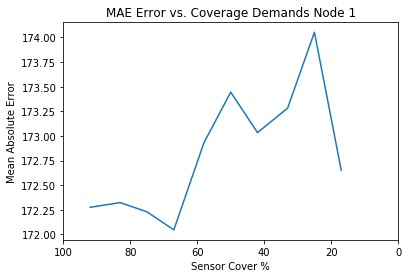

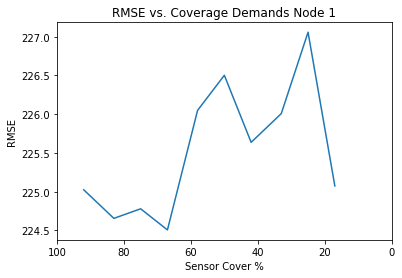

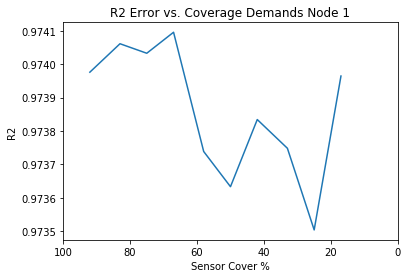

In [12]:
plt.plot(demand_sensors_covered_node1, demand_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE Error vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node1, demand_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node1, demand_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 Error vs. Coverage Demands Node 1")
plt.xlim([100, 0])
plt.show()

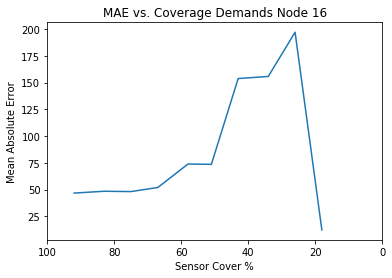

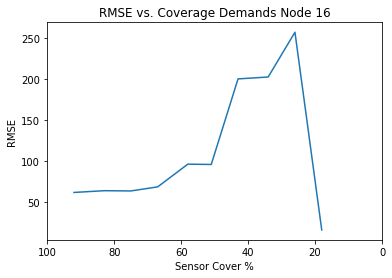

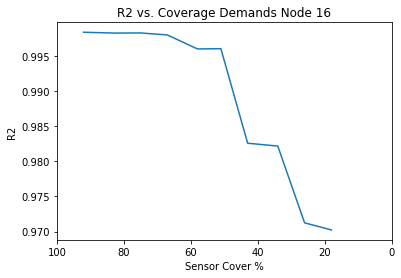

In [13]:
plt.plot(demand_sensors_covered_node16, demand_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node16, demand_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node16, demand_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Demands Node 16")
plt.xlim([100, 0])
plt.show()

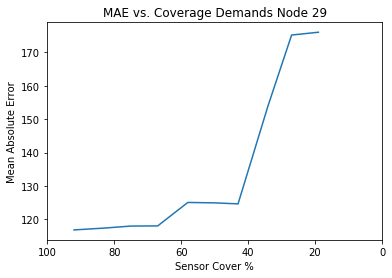

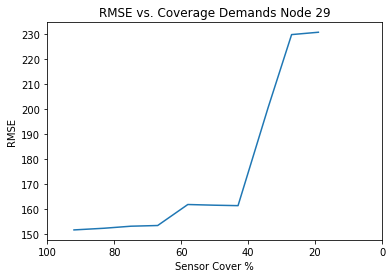

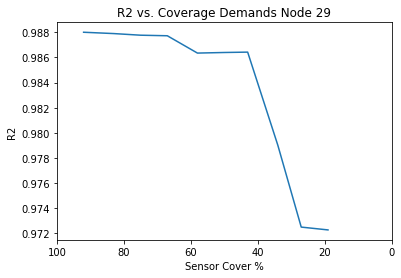

In [14]:
plt.plot(demand_sensors_covered_node29, demand_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node29, demand_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(demand_sensors_covered_node29, demand_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Demands Node 29")
plt.xlim([100, 0])
plt.show()

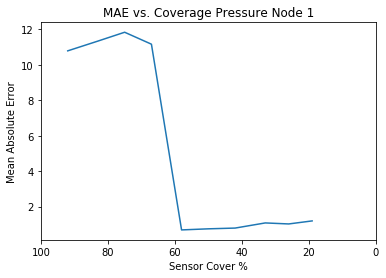

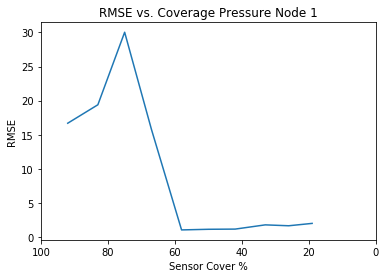

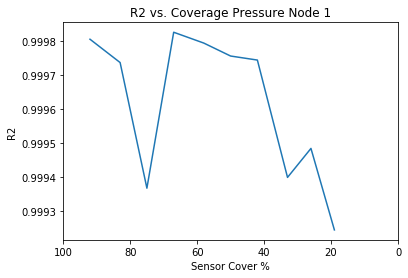

In [15]:
plt.plot(pressure_sensors_covered_node1, pressure_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node1, pressure_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node1, pressure_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 1")
plt.xlim([100, 0])
plt.show()

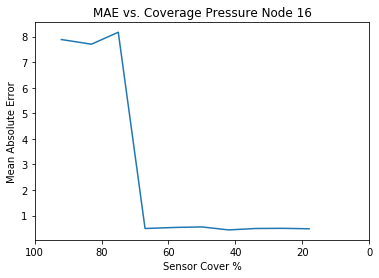

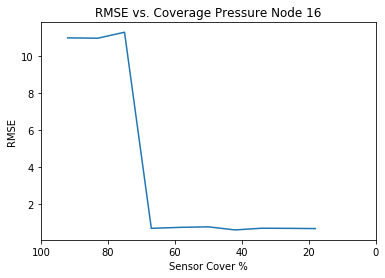

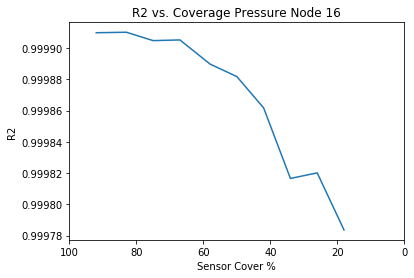

In [16]:
plt.plot(pressure_sensors_covered_node16, pressure_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node16, pressure_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node16, pressure_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 16")
plt.xlim([100, 0])
plt.show()

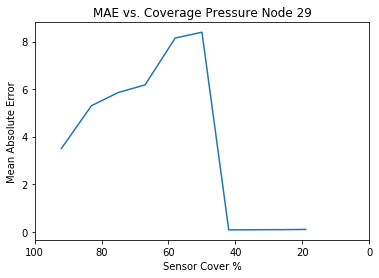

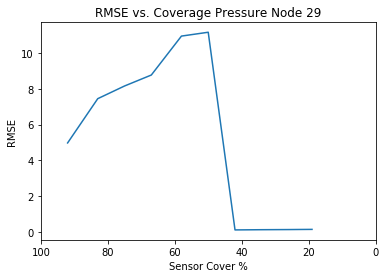

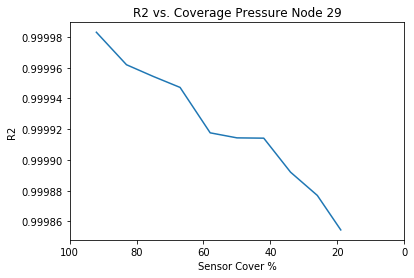

In [17]:
plt.plot(pressure_sensors_covered_node29, pressure_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node29, pressure_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(pressure_sensors_covered_node29, pressure_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

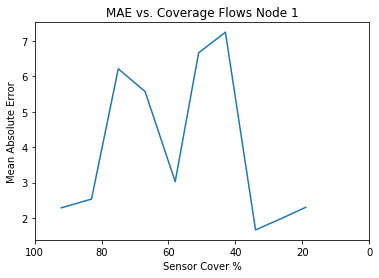

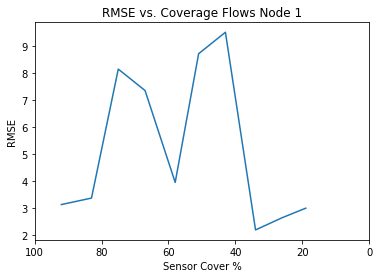

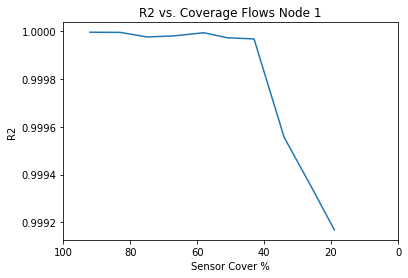

In [18]:
plt.plot(flow_sensors_covered_node1, flow_errors_mae_node1)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node1, flow_errors_rmse_node1)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node1, flow_errors_r2_node1)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 1")
plt.xlim([100, 0])
plt.show()

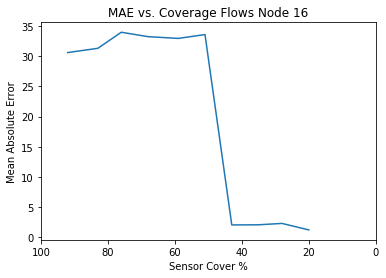

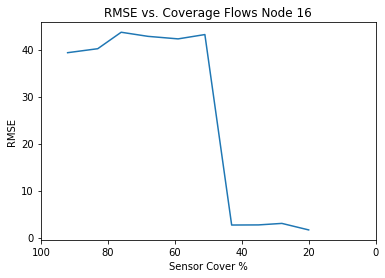

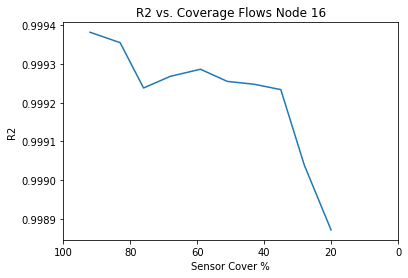

In [19]:
plt.plot(flow_sensors_covered_node16, flow_errors_mae_node16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node16, flow_errors_rmse_node16)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node16, flow_errors_r2_node16)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 16")
plt.xlim([100, 0])
plt.show()

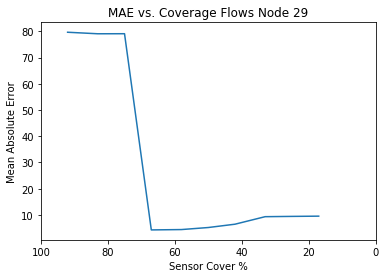

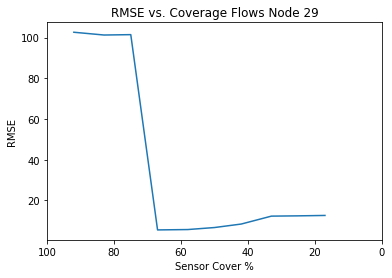

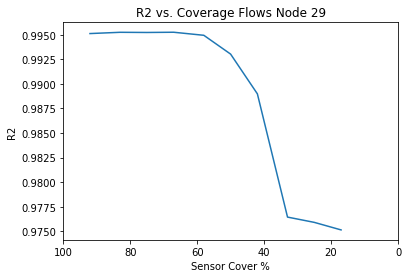

In [20]:
plt.plot(flow_sensors_covered_node29, flow_errors_mae_node29)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node29, flow_errors_rmse_node29)
plt.ylabel("RMSE")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()

plt.plot(flow_sensors_covered_node29, flow_errors_r2_node29)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Flows Node 29")
plt.xlim([100, 0])
plt.show()